# Figure: ML Models

This notebook contains the code to generate Fig.2 of the manuscript. Refer to [metadata.py](utils/metadata.py) for the mapping of model cores.


In [2]:
import pandas as pd
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from utils.utils import print_pretty_df, r, y, g, b, e
from utils.metadata import general_task_colors, assign_model_core

pickleName = "all_datapoints.pkl"
datapointsDfPath = Path("..") / "data" / "Dataframes" / pickleName
datapointsDf = pd.read_pickle(datapointsDfPath)

versionTag = "_v4"
figureName = "model_per_year" + versionTag
saveFormat = "pdf"
saveFigurePath = Path("..") / "data" / "Figures" / "RQ_figures" / f"{figureName}.{saveFormat}"

# Assign model core based on keywords in 'Model', 'Equivalent model', and 'Backbone'
datapointsDf['Model Core'] = datapointsDf.apply(assign_model_core, axis=1)
print_pretty_df(datapointsDf[["Model Core", "Model", "Equivalent model", "Backbone", "BBT Citation Key"]]) # .sort_values(by="Model Core"))

+----+------------+-------------------------------+------------------+----------------+-------------------------------------------------------+
|    | Model Core |             Model             | Equivalent model |    Backbone    |                   BBT Citation Key                    |
+----+------------+-------------------------------+------------------+----------------+-------------------------------------------------------+
| 0  | Shallow NN |            TinyML             |       MLP        |                |           hammoudFPGAONBOARDPROCESSING2024            |
| 1  |    ViT     |              VTR              |       ViT        |                |         wickramasingheVTROptimizedVision2024          |
| 2  | Custom CNN |          CloudScout           |       CNN        |                |       rapuanoFPGAbasedHardwareAccelerator2021a        |
| 3  | Custom CNN |              CNN              |       CNN        |                |          vitoloRealTimeOnboardSatellite2024     

Saving figure to ..\data\Figures\RQ_figures\model_per_year_v4.pdf.


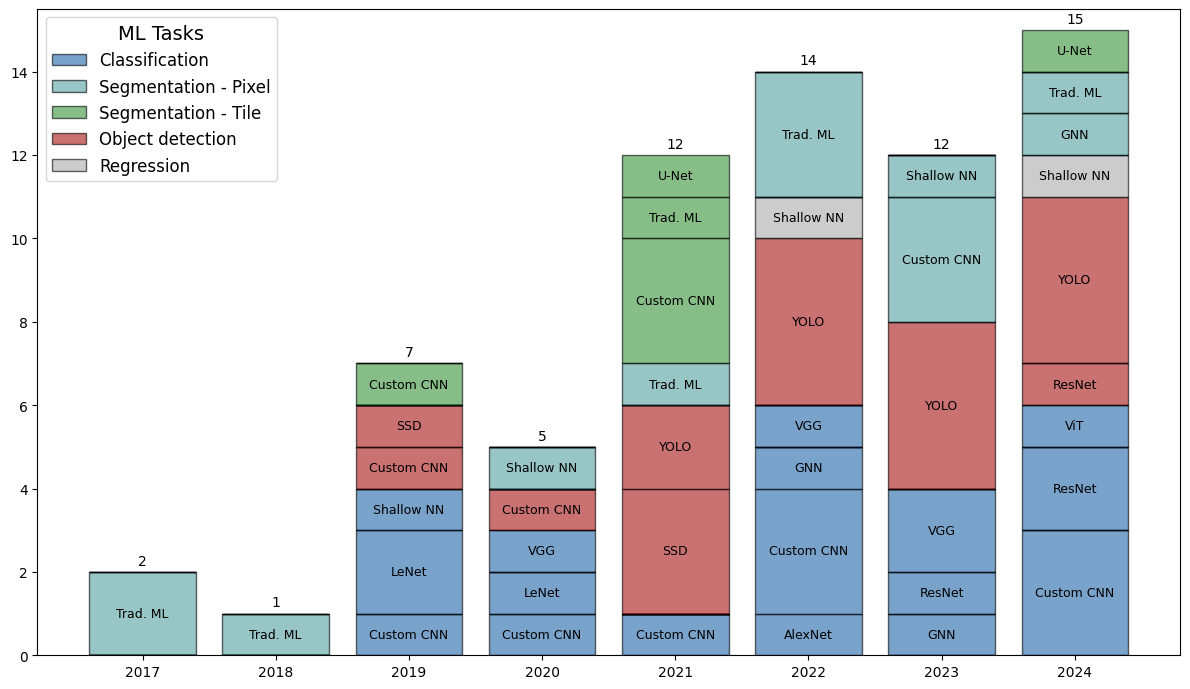

In [4]:
def plot_model_groups_by_year(DataFrame, alpha=0.6, fontsize=8):
    """
    Plot a stacked bar chart showing the number of model groups per publication year.
    Each bar represents a publication year, divided into segments for each Model Group.
    The color of each segment corresponds to the Task.
    """

    # Copy the DataFrame
    DF = DataFrame.copy()
    
    # Force the order of Tasks
    TaskOrder = ['Classification', 'Segmentation - Pixel', 'Segmentation - Tile', 'Object detection', 'Regression']
    
    # Group data by 'Publication year', 'Task', and 'Model Core', count occurrences
    Counts = DF.groupby(['Publication year', 'Task', 'Model Core']).size().reset_index(name='Count')

    # Remove entries with zero counts
    Counts = Counts[Counts['Count'] > 0]

    # Assign colors to Tasks
    TaskColors = general_task_colors
    
    # Pivot data
    PivotDF = Counts.pivot_table(
        index='Publication year',
        columns=['Task', 'Model Core'],
        values='Count',
        fill_value=0
    )

    # Ensure Tasks are in the specified order
    PivotDF = PivotDF.reindex(columns=PivotDF.columns.reindex(TaskOrder, level=0)[0], fill_value=0)
    
    # Sort columns by Task and Model Group
    PivotDF = PivotDF.sort_index(axis=1, level=[0,1], sort_remaining=False)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 7))

    Bottom = np.zeros(len(PivotDF))
    X = PivotDF.index.astype(str)
    BarWidth = 0.8

    # Calculate total counts per publication year
    TotalCounts = PivotDF.sum(axis=1)

    for (Task, ModelGroup) in PivotDF.columns:
        Counts = PivotDF[(Task, ModelGroup)].values
        if np.all(Counts == 0):
            continue  # Skip if all counts are zero
        Color = TaskColors.get(Task, '#333333')
        Bars = ax.bar(
            X,
            Counts,
            alpha=alpha,
            bottom=Bottom,
            color=Color,
            edgecolor='black',
            width=BarWidth
        )
        # Add model group name as label within sub-bar if count > 0
        Labels = [ModelGroup if count > 0 else '' for count in Counts]
        ax.bar_label(Bars, labels=Labels, label_type='center', fontsize=fontsize)
        Bottom += Counts

    # Add total count labels on top of each yearly bar
    for i, total in enumerate(TotalCounts):
        ax.text(i, TotalCounts.iloc[i] + 0.1, f"{int(TotalCounts.iloc[i])}", ha='center', va='bottom')

    # Create legend for Tasks
    task_handles = [mpatches.Patch(facecolor=TaskColors[task], edgecolor='black', alpha=alpha, label=task) for task in TaskOrder]
    ax.legend(handles=task_handles, title='ML Tasks', loc='upper left', fontsize=fontsize+3, title_fontsize=fontsize + 5)
    plt.rcParams['legend.title_fontsize'] = fontsize+5

    # ax.set_title('Model Groups by Publication Year')
    # ax.set_xlabel('Publication Year')
    # ax.set_ylabel('Count')
    plt.ylim(0, 15.5)
    plt.tight_layout()

    # Save the figure
    print(f"Saving figure to {b}{saveFigurePath}{e}.")
    plt.savefig(saveFigurePath, format=saveFormat)
    
    plt.show()

plot_model_groups_by_year(datapointsDf[['Model Core', 'Publication year', 'Task']], alpha=0.6, fontsize=9)

### Additional statistics


In [ ]:
print(datapointsDf["Model Core"].value_counts())

print(f"\nTotal number of models: {len(datapointsDf)}")
nb_trad_ml = len(datapointsDf[datapointsDf["Model Core"] == "Trad. ML"])
nb_shallow_nn = len(datapointsDf[datapointsDf["Model Core"] == "Shallow NN"])
print(f"Trad ML: {nb_trad_ml}")
print(f"Shallow NN: {nb_shallow_nn}")

nb_dl = len(datapointsDf) - nb_trad_ml - nb_shallow_nn
nb_vit = len(datapointsDf[datapointsDf["Model Core"] == "ViT"])
nb_gnn = len(datapointsDf[datapointsDf["Model Core"] == "GNN"])
nb_cnn = len(datapointsDf[datapointsDf["Model Core"].isin(["LeNet", "AlexNet", "VGG", "U-Net", "ResNet", "Custom CNN"])])
nb_custom_cnn = len(datapointsDf[datapointsDf["Model Core"] == "Custom CNN"])
nb_detection_model = len(datapointsDf[datapointsDf["Model Core"].isin(["YOLO", "SSD"])])
print(f"DL: {nb_dl} ({nb_dl/len(datapointsDf)*100:.2f}%) including {nb_vit} ViTs, {nb_gnn} GNNs, {nb_cnn} CNNs ({nb_custom_cnn} custom CNNs), and {nb_detection_model} detection models")

nb_classification = len(datapointsDf[datapointsDf["Task"] == "Classification"])
nb_object_detection = len(datapointsDf[datapointsDf["Task"] == "Object detection"])
print(f"\nNumber of experiments with task 'Classification': {nb_classification}")
print(f"Number of experiments with task 'Object detection': {nb_object_detection}")

Model Core
Custom CNN    18
YOLO          14
Trad. ML       9
Shallow NN     5
SSD            4
VGG            4
ResNet         4
LeNet          3
GNN            3
U-Net          2
ViT            1
AlexNet        1
Name: count, dtype: int64
Total number of models: 68

Trad ML: 9
Shallow NN: 5
DL: 54 (79.41%) including 1 ViTs, 3 GNNs, 32 CNNs (18 custom CNNs), and 18 detection models

Number of experiments with task 'Classification': 24
Number of experiments with task 'Object detection': 21
